In [1]:
import os
import numpy as np

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'hmog_public_dataset/'

In [2]:
import pickle

test_file = open('preprocessed_data/hmog_dataset_ww_ws', 'rb')
session_hmog_matrices = pickle.load(test_file)
test_file.close()

In [3]:
# We need to exclude subjects who used landscape orientation
landscape_subjects = ['856302', '751131', '220962', '186676', '980953', '201848', '675397']
for l_s in landscape_subjects:
    del session_hmog_matrices[l_s]

subjects_list = list(session_hmog_matrices.keys())
print(f'len: {len(subjects_list)}\n\n{subjects_list}')

len: 92

['342329', '240168', '472761', '352716', '219303', '431312', '556357', '717868', '862649', '990622', '937904', '745224', '841866', '799296', '621276', '827212', '876011', '986737', '171538', '973891', '865881', '248252', '218719', '389015', '918136', '803262', '261313', '207969', '892687', '257279', '785873', '879155', '966655', '326223', '264325', '256487', '553321', '923862', '526319', '733568', '579284', '277905', '777078', '776328', '893255', '100669', '278135', '501973', '405035', '395129', '710707', '578526', '998757', '897652', '737973', '984799', '525584', '913228', '720193', '336172', '785899', '527796', '594887', '588087', '698266', '622852', '815316', '180679', '151985', '962159', '872895', '396697', '538363', '863985', '657486', '856401', '561993', '540641', '893198', '808022', '366286', '663153', '763813', '368258', '539502', '693572', '489146', '771782', '796581', '398248', '865501', '554303']


# Windowed Tests

## Different subjects tests

In [4]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

def test_eer(session_hmog_matrices, train_key: str, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in range(len(subjects_list)):
            subject = subjects_list[i]

            train_hmog_vector = np.vstack((session_hmog_matrices[subject][train_key][0], session_hmog_matrices[subject][train_key][1]))

            std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
            train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][test_key][2], session_hmog_matrices[subject][test_key][3]))
            test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

            test_hmog_vector_negative = None
            
            if model_key == 'svm':
                model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_no_timestamp)
            elif model_key == 'se':
                model = models.SEClassifier()
                model.fit(train_hmog_vector_no_timestamp)
            elif model_key == 'sm':
                model = models.SMClassifier()
                model.fit(train_hmog_vector_no_timestamp)

            other_subjects = subjects_list.copy()
            del other_subjects[i]

            for another_subject in other_subjects:
                test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][test_key][2], session_hmog_matrices[another_subject][test_key][3]))

                if test_hmog_vector_new.shape[0] == 0:
                    continue

                if test_hmog_vector_negative is None:
                    test_hmog_vector_negative = test_hmog_vector_new
                else:
                    test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

            # Now we need to scale the whole vector
            test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

            predictions_self = HmogHelper.test_hmog_windowed_split(test_hmog_vector_positive, t_window_ms=window_size, model=model)
            y_true = [pos_val] * len(predictions_self)

            predictions_others = HmogHelper.test_hmog_windowed_split(test_hmog_vector_negative, t_window_ms=window_size, model=model)
            y_true += ([neg_val] * len(predictions_others))
            
            scores = predictions_self + predictions_others
            
            # we need to normalize the vectors in case the models are SE or SM
            if model_key == 'se' or model_key == 'sm':
                scores /= max(scores)

            fpr, tpr, thresholds = roc_curve(y_true, scores)

            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
            
            # Append EER to the list
            eer_list.append(eer)
        
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [3]:
def test_eer_no_neg_stack(session_hmog_matrices, train_key: str, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in range(len(subjects_list)):
            curr_subj_eers = []

            subject = subjects_list[i]

            train_hmog_vector = np.vstack((session_hmog_matrices[subject][train_key][0], session_hmog_matrices[subject][train_key][1]))

            std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
            train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][test_key][2], session_hmog_matrices[subject][test_key][3]))
            test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)
            
            if model_key == 'svm':
                model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_no_timestamp)
            elif model_key == 'se':
                model = models.SEClassifier()
                model.fit(train_hmog_vector_no_timestamp)
            elif model_key == 'sm':
                model = models.SMClassifier()
                model.fit(train_hmog_vector_no_timestamp)

            other_subjects = subjects_list.copy()
            del other_subjects[i]

            for another_subject in other_subjects:
                test_hmog_vector_negative = np.vstack((session_hmog_matrices[another_subject][test_key][2], session_hmog_matrices[another_subject][test_key][3]))

                if test_hmog_vector_negative.shape[0] == 0:
                    continue

                # Now we need to scale the whole vector
                test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)
    
                predictions_self = HmogHelper.test_hmog_windowed_split(test_hmog_vector_positive, t_window_ms=window_size, model=model)
                y_true = [pos_val] * len(predictions_self)
    
                predictions_others = HmogHelper.test_hmog_windowed_split(test_hmog_vector_negative, t_window_ms=window_size, model=model)
                y_true += ([neg_val] * len(predictions_others))
                
                scores = predictions_self + predictions_others
                
                # we need to normalize the vectors in case the models are SE or SM
                if model_key == 'se' or model_key == 'sm':
                    scores /= max(scores)
    
                fpr, tpr, thresholds = roc_curve(y_true, scores)
    
                # Find the threshold where FPR equals FNR
                eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
                eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
                
                # Append EER to the list
                curr_subj_eers.append(eer)
            
            eer_list.append(np.mean(curr_subj_eers))
        
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [10]:
svm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'svm', 1, -1)
svm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'svm', 1, -1)
svm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'svm', 1, -1)
svm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'svm', 1, -1)

Window size: 20.0s
Population EER: 0.1529992278868255
Window size: 40.0s
Population EER: 0.14460728159284708
Window size: 60.0s
Population EER: 0.1435655901751336
Window size: 80.0s
Population EER: 0.13708822997182254
Window size: 100.0s
Population EER: 0.12702076277349977
Window size: 120.0s
Population EER: 0.1406794888583894
Window size: 140.0s
Population EER: 0.13551386690688752
Done
Window size: 20.0s
Population EER: 0.2014964597986965
Window size: 40.0s
Population EER: 0.1950320185809405
Window size: 60.0s
Population EER: 0.19154996499177232
Window size: 80.0s
Population EER: 0.20448601279051726
Window size: 100.0s
Population EER: 0.1992023126540306


KeyboardInterrupt: 

In [18]:
se_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'se', 0, 1)
se_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'se', 0, 1)
se_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'se', 0, 1)
se_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'se', 0, 1)

Window size: 20.0s
Population EER: 0.16289019411261532
Window size: 40.0s
Population EER: 0.15649402470651072
Window size: 60.0s
Population EER: 0.13823614504029005
Window size: 80.0s
Population EER: 0.13271698574883556


KeyboardInterrupt: 

In [15]:
sm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'sm', 0, 1)
sm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'sm', 0, 1)
sm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'sm', 0, 1)
sm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'sm', 0, 1)

Window size: 20.0s
Population EER: 0.8496460785045757


KeyboardInterrupt: 

# Data Pickling

In [11]:
import pickle
import os

def pickle_results(values: list, results_path: str, filename: str):
    abs_path = os.path.join(results_path, filename)
    if not os.path.exists(abs_path):
        result_file = open(abs_path, 'wb')
        pickle.dump(values, result_file)
        result_file.close()

In [39]:
# pickle_results(list(svm_ww_ww_eers.values()), 'results/', 'svm_ww_ww_eers')
# pickle_results(list(svm_ws_ws_eers.values()), 'results/', 'svm_ws_ws_eers')
# pickle_results(list(svm_ww_ws_eers.values()), 'results/', 'svm_ww_ws_eers')
# pickle_results(list(svm_ws_ww_eers.values()), 'results/', 'svm_ws_ww_eers')
# 
# pickle_results(list(se_ww_ww_eers.values()), 'results/', 'se_ww_ww_eers')
# pickle_results(list(se_ws_ws_eers.values()), 'results/', 'se_ws_ws_eers')
# pickle_results(list(se_ww_ws_eers.values()), 'results/', 'se_ww_ws_eers')
# pickle_results(list(se_ws_ww_eers.values()), 'results/', 'se_ws_ww_eers')
# 
# pickle_results(list(sm_ww_ww_eers.values()), 'results/', 'sm_ww_ww_eers')
# pickle_results(list(sm_ws_ws_eers.values()), 'results/', 'sm_ws_ws_eers')
# pickle_results(list(sm_ww_ws_eers.values()), 'results/', 'sm_ww_ws_eers')
# pickle_results(list(sm_ws_ww_eers.values()), 'results/', 'sm_ws_ww_eers')

# Visualisations

## Tables
Let's put all results into a table (window_size vs. sm/se/oneclasssvm)

In [1]:
# But firstly, let's load saved data since testing takes noticeable amount of time
import pickle
import os

def load_result(path_to_file: str):
    if os.path.exists(path_to_file):
        result_file = open(path_to_file, 'rb')
        result = pickle.load(result_file)
        result_file.close()

        return result
    return []

In [2]:
svm_ww_ww_eers = load_result('results/svm_ww_ww_eers')
svm_ws_ws_eers = load_result('results/svm_ws_ws_eers')
svm_ww_ws_eers = load_result('results/svm_ww_ws_eers')
svm_ws_ww_eers = load_result('results/svm_ws_ww_eers')

se_ww_ww_eers = load_result('results/se_ww_ww_eers')
se_ws_ws_eers = load_result('results/se_ws_ws_eers')
se_ww_ws_eers = load_result('results/se_ww_ws_eers')
se_ws_ww_eers = load_result('results/se_ws_ww_eers')

sm_ww_ww_eers = load_result('results/sm_ww_ww_eers')
sm_ws_ws_eers = load_result('results/sm_ws_ws_eers')
sm_ww_ws_eers = load_result('results/sm_ww_ws_eers')
sm_ws_ww_eers = load_result('results/sm_ws_ww_eers')

In [8]:
from tabulate import tabulate

windows_seconds = [size / 1000 for size in WINDOW_SIZES]
header = ['Model'] + [f'{window_s}s.' for window_s in windows_seconds]

table_ww_ww = [header,
              ['OneClassSVM'] + svm_ww_ww_eers,
              ['SE'] + se_ww_ww_eers,
              ['SM'] + sm_ww_ww_eers]

table_ws_ws = [header,
              ['OneClassSVM'] + svm_ws_ws_eers,
              ['SE'] + se_ws_ws_eers,
              ['SM'] + sm_ws_ws_eers]

table_ww_ws = [header,
              ['OneClassSVM'] + svm_ww_ws_eers,
              ['SE'] + se_ww_ws_eers,
              ['SM'] + sm_ww_ws_eers]

table_ws_ww = [header,
              ['OneClassSVM'] + svm_ws_ww_eers,
              ['SE'] + se_ws_ww_eers,
              ['SM'] + sm_ws_ww_eers]

print('walking + walking tests\n', tabulate(table_ww_ww, headers='firstrow'), end='\n\n')
print('sitting + sitting tests\n', tabulate(table_ws_ws, headers='firstrow'), end='\n\n')
print('walking + sitting tests\n', tabulate(table_ww_ws, headers='firstrow'), end='\n\n')
print('sitting + walking tests\n', tabulate(table_ws_ww, headers='firstrow'), end='\n\n')

walking + walking tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.152999  0.144607  0.143566  0.137088   0.127021   0.140679   0.135514
SE           0.16289   0.156494  0.138236  0.132717   0.130496   0.13546    0.135487
SM           0.150354  0.120183  0.112233  0.105297   0.103094   0.104411   0.103937

sitting + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.201496  0.195032  0.19155   0.204486   0.199202   0.198113   0.203696
SE           0.181461  0.177696  0.175972  0.176495   0.182432   0.178428   0.195729
SM           0.153295  0.13154   0.126397  0.132979   0.133861   0.141356   0.159158

walking + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.

## Plots

In [6]:
import matplotlib.pyplot as plt

def plot(data: list, xlabel: str, ylabel: str, title: str):
    y_lim_lower = 0
    y_lim_upper = 0.6

    for values, curve_label in data:
        plt.plot(windows_seconds, list(values), linestyle='dotted', label=curve_label)

    plt.ylim(y_lim_lower, y_lim_upper)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

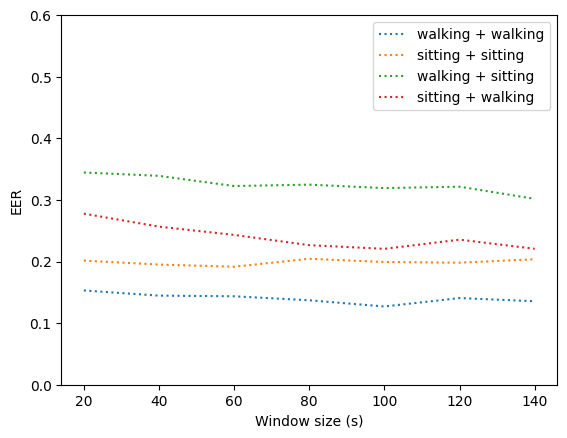

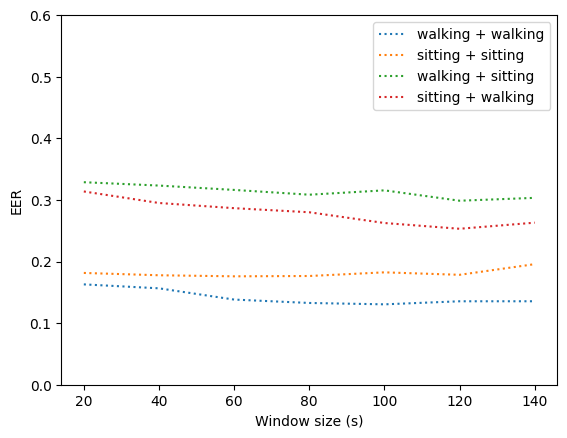

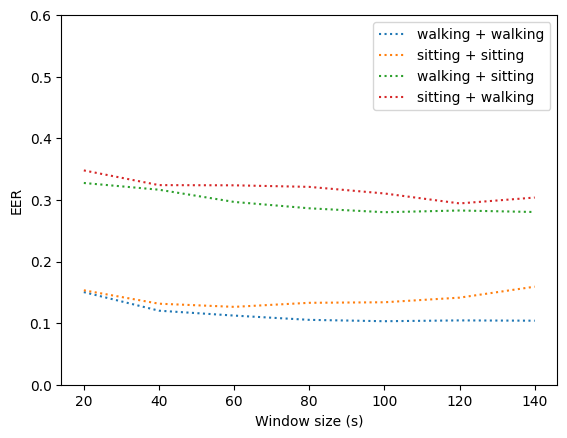

In [12]:
svm_all_data_comparison = [(svm_ww_ww_eers, 'walking + walking'),
                           (svm_ws_ws_eers, 'sitting + sitting'),
                           (svm_ww_ws_eers, 'walking + sitting'),
                           (svm_ws_ww_eers, 'sitting + walking')]

se_all_data_comparison = [(se_ww_ww_eers, 'walking + walking'),
                          (se_ws_ws_eers, 'sitting + sitting'),
                          (se_ww_ws_eers, 'walking + sitting'),
                          (se_ws_ww_eers, 'sitting + walking')]

sm_all_data_comparison = [(sm_ww_ww_eers, 'walking + walking'),
                          (sm_ws_ws_eers, 'sitting + sitting'),
                          (sm_ww_ws_eers, 'walking + sitting'),
                          (sm_ws_ww_eers, 'sitting + walking')]

# plot(svm_all_data_comparison, 'Window size (s)', 'EER', 'OneClassSVM')
# plot(se_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Euclidean')
# plot(sm_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Manhattan')

plot(svm_all_data_comparison, 'Window size (s)', 'EER', '')
plot(se_all_data_comparison, 'Window size (s)', 'EER', '')
plot(sm_all_data_comparison, 'Window size (s)', 'EER', '')

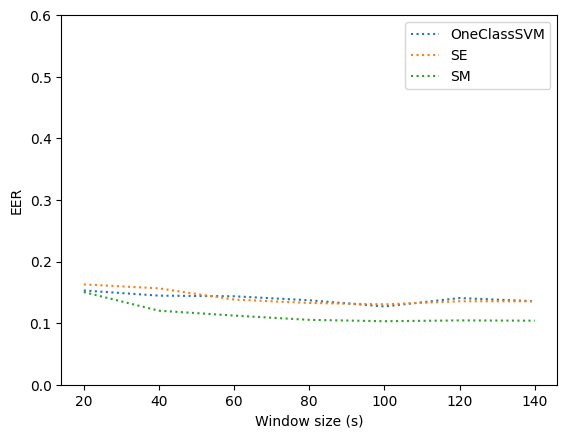

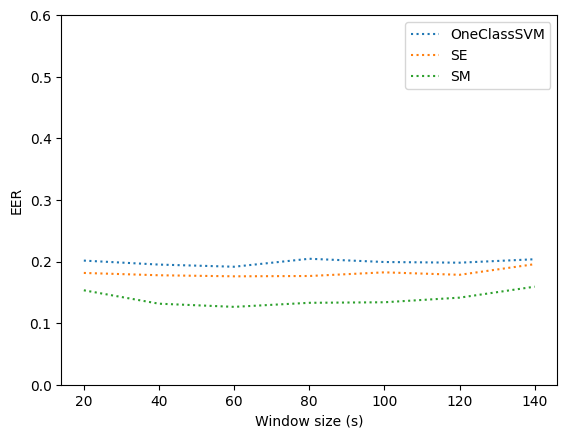

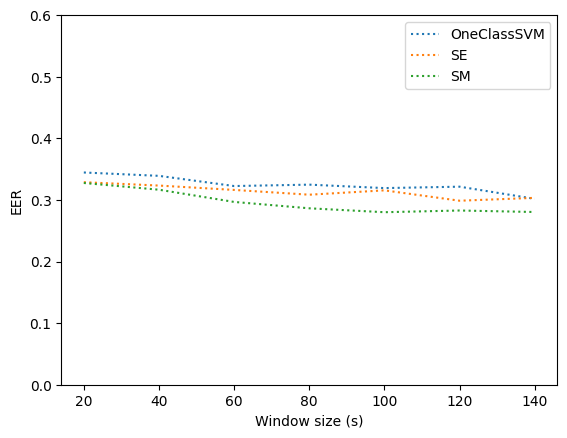

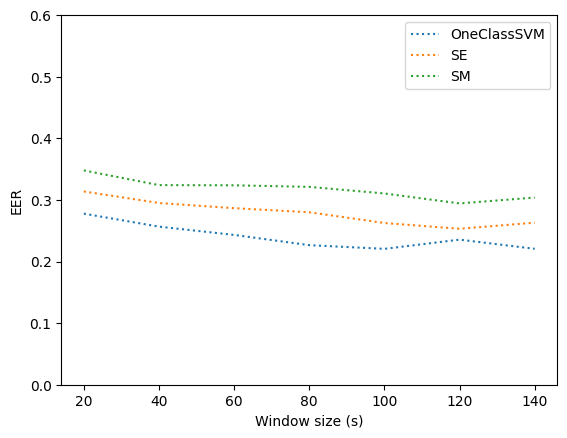

In [10]:
ww_ww_data_comparison = [(svm_ww_ww_eers, 'OneClassSVM'),
                      (se_ww_ww_eers, 'SE'),
                      (sm_ww_ww_eers, 'SM')]

ws_ws_data_comparison = [(svm_ws_ws_eers, 'OneClassSVM'),
                         (se_ws_ws_eers, 'SE'),
                         (sm_ws_ws_eers, 'SM')]

ww_ws_data_comparison = [(svm_ww_ws_eers, 'OneClassSVM'),
                         (se_ww_ws_eers, 'SE'),
                         (sm_ww_ws_eers, 'SM')]

ws_ww_data_comparison = [(svm_ws_ww_eers, 'OneClassSVM'),
                         (se_ws_ww_eers, 'SE'),
                         (sm_ws_ww_eers, 'SM')]

# plot(ww_ww_data_comparison, 'Window size (s)', 'EER', 'walking + walking comparison')
# plot(ws_ws_data_comparison, 'Window size (s)', 'EER', 'sitting + sitting comparison')
# plot(ww_ws_data_comparison, 'Window size (s)', 'EER', 'walking + sitting comparison')
# plot(ws_ww_data_comparison, 'Window size (s)', 'EER', 'sitting + walking comparison')

plot(ww_ww_data_comparison, 'Window size (s)', 'EER', '')
plot(ws_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(ww_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(ws_ww_data_comparison, 'Window size (s)', 'EER', '')

## Tests with activity classification model

Let's for each subject:
1. Train two models: the first one on sitting sessions and the second one on walking sessions
2. Use a model that classifies current activity (walking or sitting)
3. Based on output of that model, pick an authentication model

Let's do that for separate tests on walking and sitting

In [4]:
import torch.nn as nn

class SimpleNeuralNet(nn.Module):
    def __init__(self) -> None:
        super(SimpleNeuralNet, self).__init__()

        input_shape = 64

        self.fc1 = nn.Linear(input_shape, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.out(x)

        return x

In [5]:
def load_activity_model():
    return torch.load('classification_model_059')

In [6]:
# TODO: finish!

import torch

from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
ACTIVITY_THRESHOLD = 0.5

model_activity = load_activity_model()
model_activity.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test_eer_with_activity(session_hmog_matrices, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in range(len(subjects_list)):
            subject = subjects_list[i]
            
            # We train two models: on walking and sitting sessions
            train_walk_hmog_vector = np.vstack((session_hmog_matrices[subject]['w'][0], session_hmog_matrices[subject]['w'][1]))
            train_sit_hmog_vector  = np.vstack((session_hmog_matrices[subject]['s'][0], session_hmog_matrices[subject]['s'][1]))

            std_deviations = {}
            std_deviations['w'], train_walk_hmog_vector = HmogHelper.calc_std_and_scale(train_walk_hmog_vector)
            std_deviations['s'], train_sit_hmog_vector = HmogHelper.calc_std_and_scale(train_sit_hmog_vector)
            
            train_walk_hmog_vector_no_timestamp = np.delete(train_walk_hmog_vector, 0, axis=1)
            train_sit_hmog_vector_no_timestamp =  np.delete(train_sit_hmog_vector, 0, axis=1)

            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][test_key][2], session_hmog_matrices[subject][test_key][3]))
            test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations[test_key])

            test_hmog_vector_negative = None
            
            if model_key == 'svm':
                model_walk = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_walk_hmog_vector_no_timestamp)
                model_sit  = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_sit_hmog_vector_no_timestamp)
            elif model_key == 'se':
                model_walk = models.SEClassifier()
                model_sit = models.SEClassifier()
                
                model_walk.fit(train_walk_hmog_vector_no_timestamp)
                model_sit.fit(train_sit_hmog_vector_no_timestamp)
            elif model_key == 'sm':
                model_walk = models.SMClassifier()
                model_sit = models.SMClassifier()
                
                model_walk.fit(train_walk_hmog_vector_no_timestamp)
                model_sit.fit(train_sit_hmog_vector_no_timestamp)

            other_subjects = subjects_list.copy()
            del other_subjects[i]

            for another_subject in other_subjects:
                test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][test_key][2], session_hmog_matrices[another_subject][test_key][3]))

                if test_hmog_vector_new.shape[0] == 0:
                    continue

                if test_hmog_vector_negative is None:
                    test_hmog_vector_negative = test_hmog_vector_new
                else:
                    test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

            # hmog_vectors_combined = np.vstack((test_hmog_vector_positive, test_hmog_vector_negative))[:, 1:]
            hmog_vectors_activity = test_hmog_vector_negative[:, 1:]
            hmog_vectors_combined_tensor = torch.tensor(hmog_vectors_activity).to(device, dtype=torch.float32)

            # Now let's predict if current test vector contains walking or sitting data
            activity_predictions = model_activity.forward(hmog_vectors_combined_tensor).reshape(-1).cpu().detach().numpy()
            walking_confidence = np.mean(activity_predictions)
            
            if walking_confidence >= ACTIVITY_THRESHOLD:
                model = model_walk
            else:
                model = model_sit
            
            # Now we need to scale the whole vector
            test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations[test_key])

            predictions_self = HmogHelper.test_hmog_windowed(test_hmog_vector_positive, t_window=window_size, model=model)
            y_true = [pos_val] * len(predictions_self)

            predictions_others = HmogHelper.test_hmog_windowed(test_hmog_vector_negative, t_window=window_size, model=model)
            y_true += ([neg_val] * len(predictions_others))

            scores = predictions_self + predictions_others

            fpr, tpr, thresholds = roc_curve(y_true, scores)

            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
            
            # Append EER to the list
            eer_list.append(eer)
        
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [7]:
svm_act_ww_eers = test_eer_with_activity(session_hmog_matrices, 'w', 'svm', 1, -1)
svm_act_ws_eers = test_eer_with_activity(session_hmog_matrices, 's', 'svm', 1, -1)

Window size: 20.0s
Population EER: 0.1529992278868255
Window size: 40.0s
Population EER: 0.14460728159284708
Window size: 60.0s
Population EER: 0.1435655901751336
Window size: 80.0s
Population EER: 0.13708822997182254
Window size: 100.0s
Population EER: 0.12702076277349977
Window size: 120.0s
Population EER: 0.1406794888583894
Window size: 140.0s
Population EER: 0.13551386690688752
Done
Window size: 20.0s
Population EER: 0.2014964597986965
Window size: 40.0s
Population EER: 0.1950320185809405
Window size: 60.0s
Population EER: 0.19154996499177232
Window size: 80.0s
Population EER: 0.20448601279051726
Window size: 100.0s
Population EER: 0.1992023126540306
Window size: 120.0s
Population EER: 0.19811284799722637
Window size: 140.0s
Population EER: 0.2036956973417971
Done


In [9]:
se_act_ww_eers = test_eer_with_activity(session_hmog_matrices, 'w', 'se', 0, 1)
se_act_ws_eers = test_eer_with_activity(session_hmog_matrices, 's', 'se', 0, 1)

Window size: 20.0s
Population EER: 0.16289019411261532
Window size: 40.0s
Population EER: 0.15649402470651072
Window size: 60.0s
Population EER: 0.13823614504029005
Window size: 80.0s
Population EER: 0.13271698574883556
Window size: 100.0s
Population EER: 0.13049591444977865
Window size: 120.0s
Population EER: 0.13546037919695883
Window size: 140.0s
Population EER: 0.135487345744236
Done
Window size: 20.0s
Population EER: 0.1814610687762304
Window size: 40.0s
Population EER: 0.17769647078760223
Window size: 60.0s
Population EER: 0.1759724715999561
Window size: 80.0s
Population EER: 0.1764946033901316
Window size: 100.0s
Population EER: 0.18243166530452845
Window size: 120.0s
Population EER: 0.17842844574995076
Window size: 140.0s
Population EER: 0.1957293578976763
Done


In [10]:
sm_act_ww_eers = test_eer_with_activity(session_hmog_matrices, 'w', 'sm', 0, 1)
sm_act_ws_eers = test_eer_with_activity(session_hmog_matrices, 's', 'sm', 0, 1)

Window size: 20.0s
Population EER: 0.15035392149542434
Window size: 40.0s
Population EER: 0.12018275275090154
Window size: 60.0s
Population EER: 0.11223300931810712
Window size: 80.0s
Population EER: 0.10529697181317828
Window size: 100.0s
Population EER: 0.10309369983851503
Window size: 120.0s
Population EER: 0.10441135233119506
Window size: 140.0s
Population EER: 0.10393745426387771
Done
Window size: 20.0s
Population EER: 0.1532951821500744
Window size: 40.0s
Population EER: 0.13153961466119582
Window size: 60.0s
Population EER: 0.12639671471634828
Window size: 80.0s
Population EER: 0.13297869303733564
Window size: 100.0s
Population EER: 0.13386129315973508
Window size: 120.0s
Population EER: 0.1413557618287872
Window size: 140.0s
Population EER: 0.15915838211834057
Done


In [12]:
pickle_results(list(svm_act_ww_eers.values()), 'results/with_activity_recog/', 'svm_act_ww_eers')
pickle_results(list(svm_act_ws_eers.values()), 'results/with_activity_recog/', 'svm_act_ws_eers')

pickle_results(list(se_act_ww_eers.values()), 'results/with_activity_recog/', 'se_act_ww_eers')
pickle_results(list(se_act_ws_eers.values()), 'results/with_activity_recog/', 'se_act_ws_eers')

pickle_results(list(sm_act_ww_eers.values()), 'results/with_activity_recog/', 'sm_act_ww_eers')
pickle_results(list(sm_act_ws_eers.values()), 'results/with_activity_recog/', 'sm_act_ws_eers')

## Visualisations of Results with Activity Recognition

In [14]:
svm_act_ww_eers = load_result('results/with_activity_recog/svm_act_ww_eers')
svm_act_ws_eers = load_result('results/with_activity_recog/svm_act_ws_eers')

se_act_ww_eers = load_result('results/with_activity_recog/se_act_ww_eers')
se_act_ws_eers = load_result('results/with_activity_recog/se_act_ws_eers')

sm_act_ww_eers = load_result('results/with_activity_recog/sm_act_ww_eers')
sm_act_ws_eers = load_result('results/with_activity_recog/sm_act_ws_eers')

In [11]:
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
windows_seconds = [size / 1000 for size in WINDOW_SIZES]

svm_ww_ws_vs_act_ws_data_comparison = [(svm_act_ws_eers, 'multi-level OneClassSVM'),
                                       (svm_ww_ws_eers, 'OneClassSVM')]
svm_ws_ww_vs_act_ww_data_comparison = [(svm_act_ww_eers, 'multi-level OneClassSVM'),
                                       (svm_ws_ww_eers, 'OneClassSVM')]

se_ww_ws_vs_act_ws_data_comparison = [(se_act_ws_eers, 'multi-level SE'),
                                       (se_ww_ws_eers, 'SE')]
se_ws_ww_vs_act_ww_data_comparison = [(se_act_ww_eers, 'multi-level SE'),
                                       (se_ws_ww_eers, 'SE')]

sm_ww_ws_vs_act_ws_data_comparison = [(sm_act_ws_eers, 'multi-level SM'),
                                       (sm_ww_ws_eers, 'SM')]
sm_ws_ww_vs_act_ww_data_comparison = [(sm_act_ww_eers, 'multi-level SM'),
                                       (sm_ws_ww_eers, 'SM')]

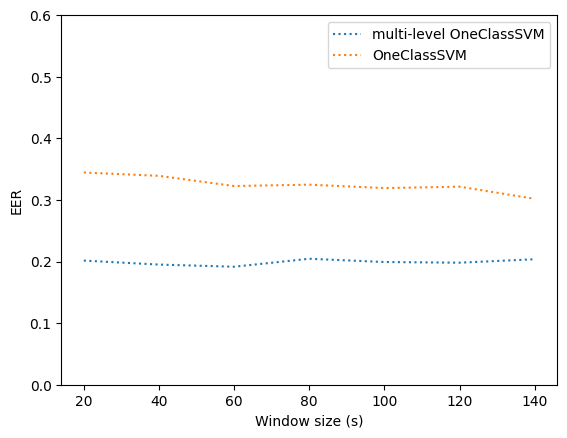

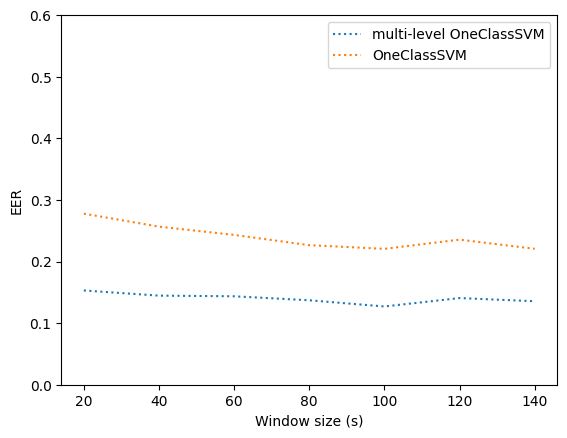

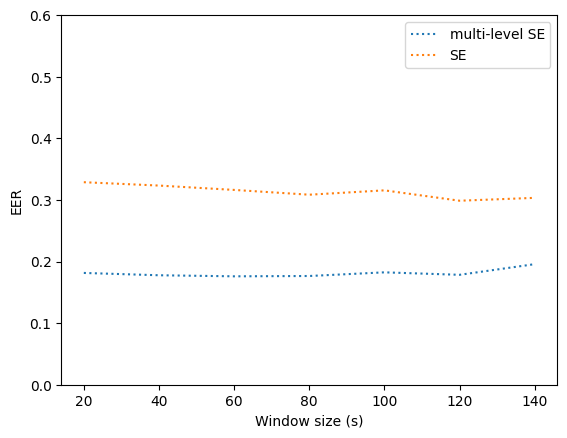

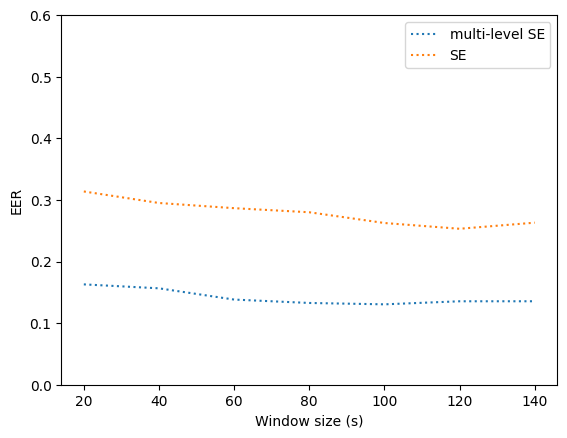

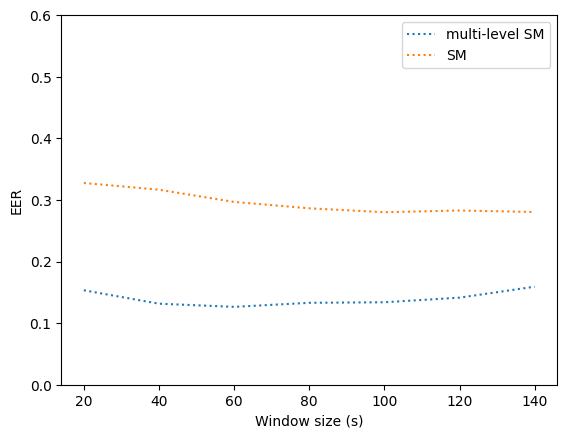

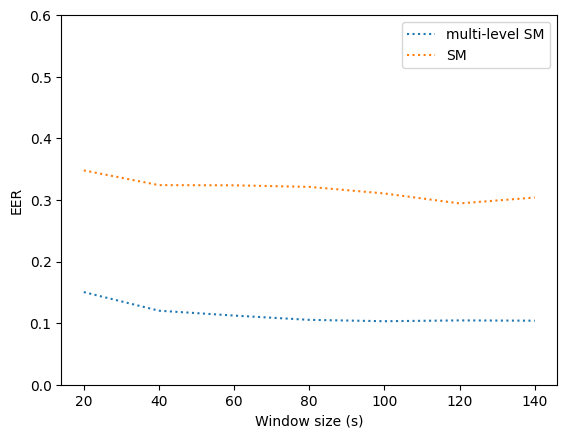

In [13]:
plot(svm_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(svm_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

plot(se_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(se_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

plot(sm_ww_ws_vs_act_ws_data_comparison, 'Window size (s)', 'EER', '')
plot(sm_ws_ww_vs_act_ww_data_comparison, 'Window size (s)', 'EER', '')

## Improvement in numbers

In [19]:
import matplotlib.pyplot as plt

avg_svm_ws_eer = np.mean(svm_ww_ws_eers)
avg_se_ws_eer = np.mean(se_ww_ws_eers)
avg_sm_ws_eer = np.mean(sm_ww_ws_eers)

avg_svm_ww_eer = np.mean(svm_ww_ww_eers)
avg_se_ww_eer = np.mean(se_ww_ww_eers)
avg_sm_ww_eer = np.mean(sm_ww_ww_eers)

avg_svm_act_ws_eer = np.mean(svm_act_ws_eers)
avg_se_act_ws_eer = np.mean(se_act_ws_eers)
avg_sm_act_ws_eer = np.mean(sm_act_ws_eers)

avg_svm_act_ww_eer = np.mean(svm_act_ww_eers)
avg_se_act_ww_eer = np.mean(se_act_ww_eers)
avg_sm_act_ww_eer = np.mean(sm_act_ww_eers)

print(avg_svm_ws_eer / avg_svm_act_ws_eer, avg_svm_ws_eer, avg_svm_act_ws_eer)

1.6313468578417691 0.3247721014160834 0.1990821877364258
